## Set up Dataset

In [72]:
import sys
sys.path.append('/home/sgf2/DBMI_server/drug_repo/molecule_ge_coordinated_embeddings/molecule_ge_coordinated_embeddings/')

import datasets as datasets
import models as models
import losses as losses
import utils
import config as cf
import torch

import pickle
import os

BASE_DIR = "../experiments/V3/drug_cell_split/757fec7c00aa9f62b42dcdfaaac3d958/"
MODEL_PATH = os.path.join(BASE_DIR, "checkpoint_757fec7c00aa9f62b42dcdfaaac3d958_val_mrr=0.03395276958079084.pth")

config = cf.read_json(os.path.join(BASE_DIR, "experiment_config.json"))
config['exp_dir'] = os.path.join(config["trainer"]["base_exp_dir"], config["model_name"])

config['device_num'] = 4

torch.cuda.set_device(config['device_num'])

# Load Train Dataset
if "precomputed_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["precomputed_train"], "rb"))
elif "save_train" in config['dataset']:
    train_dataset = pickle.load(open(config['dataset']["save_train"], "rb"))
else:
    train_dataset = cf.initialize_from_config(config, 'dataset', datasets)

# Force Test Set
val_dataset = cf.initialize_from_config(config, 'dataset', datasets, split="test")

train_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, train_dataset, shuffle=True)
val_loader = cf.initialize_from_config(config, 'data_loader', torch.utils.data, val_dataset)

# Wrappers for embedding evaluation
ge_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, train_dataset)
ge_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_ge', datasets, val_dataset)
smiles_wrapper_train = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, train_dataset)
smiles_wrapper_val = cf.initialize_from_config(config, 'dataset_wrapper_smiles', datasets, val_dataset)

uniq_train_perts = set(smiles_wrapper_train.pert_smiles)
uniq_val_perts = set(smiles_wrapper_val.pert_smiles)

ge_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_train)
ge_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, ge_wrapper_val)
smiles_loader_train = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_train)
smiles_loader_val = cf.initialize_from_config(config, 'data_loader_singlet', torch.utils.data, smiles_wrapper_val)

smiles_to_feats = datasets.smiles_to_rdkit_feats(list(uniq_train_perts.union(uniq_val_perts)))


model = cf.initialize_from_config(config, 'model', models, n_feats_genes=train_dataset.n_feats_genes,
                                              smiles_to_feats=smiles_to_feats)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

### Load Model

In [73]:
if 'rdkit_features' in config and config['rdkit_features']:
    chemprop_model_pretrained = models.load_chemprop_model("/home/sgf2/DBMI_server/drug_repo/chemprop/pcba/model_optimized.pt")
else:
    chemprop_model_pretrained = models.load_chemprop_model("/home/sgf2/DBMI_server/drug_repo/chemprop/pcba/model_unoptimized.pt")

In [74]:
import numpy as np

def get_embeddings(model, ge_wrapper, ge_loader, smiles_wrapper, smiles_loader):
    gex_raw = np.zeros([ge_wrapper.__len__(), ge_wrapper.__getitem__(0)[0].shape[0]])
    gex_embeddings = np.zeros([ge_wrapper.__len__(), model.embed_size])
    smiles_gex_labels = []
    smiles_chem_labels = []
    chem_embeddings = np.zeros([smiles_wrapper.__len__(), model.embed_size])
    
    if 'rdkit_features' in config and config['rdkit_features']:
        nfeats_chemprop = 2400
    else:
        nfeats_chemprop = 300
    chem_embeddings_chemprop = np.zeros([smiles_wrapper.__len__(), nfeats_chemprop])
    # smiles_strings = smiles_wrapper.pert_smiles

    model.eval()
    with torch.no_grad():
        # GE embeds for all of train
        for i, batch in enumerate(ge_loader):
            gex = batch[0].cuda()
            start_ind = i * ge_loader.batch_size
            end_ind = start_ind + gex.shape[0]

            smiles_gex_labels.extend(batch[1])
            gex_embeddings[start_ind:end_ind, :] = model.ge_embed(gex).cpu().numpy()
            gex_raw[start_ind:end_ind, :] = gex.cpu().numpy()

        # Embeds for all unique chems
        for i, batch in enumerate(smiles_loader):
            smiles = batch
            smiles_chem_labels.extend(batch)
            start_ind = i * smiles_loader.batch_size
            end_ind = start_ind + len(smiles)
            if 'rdkit_features' in config and config['rdkit_features']:
                feats = [smiles_to_feats[x] for x in smiles]
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles, feats))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles, feats)
            else:
                chem_embeds = model.chem_linear(model.chemprop_encoder(smiles))
                chem_embeds_chemprop = chemprop_model_pretrained(smiles)
            chem_embeddings[start_ind:end_ind, :] = chem_embeds.cpu().numpy()
            chem_embeddings_chemprop[start_ind:end_ind, :] = chem_embeds_chemprop.cpu().numpy()
            
    # Embeddings for all chems in train
    smile_to_chem = {}
    smile_to_chem_cp = {}
    for i, smile in enumerate(smiles_chem_labels):
        smile_to_chem[smile] = chem_embeddings[i,:]
        smile_to_chem_cp[smile] = chem_embeddings_chemprop[i,:]

    chem_embeddings_all = []
    chem_embeddings_all_chemprop = []
    for smile in smiles_gex_labels:
        chem_embeddings_all.append(smile_to_chem[smile])
        chem_embeddings_all_chemprop.append(smile_to_chem_cp[smile])
    chem_embeddings_all = np.stack(chem_embeddings_all)
    chem_embeddings_all_chemprop = np.stack(chem_embeddings_all_chemprop)

    return (np.nan_to_num(gex_raw), np.nan_to_num(gex_embeddings),
            np.nan_to_num(chem_embeddings_all), np.nan_to_num(chem_embeddings),
            np.nan_to_num(chem_embeddings_all_chemprop), np.nan_to_num(chem_embeddings_chemprop),
            np.array(smiles_gex_labels), np.array(smiles_chem_labels))

In [75]:
gex_raw_train, gex_embeddings_train, chem_embeddings_train, chem_embeddings_unique_train, chem_embeddings_chemprop_train, chem_embeddings_unique_chemprop_train, smiles_gex_labels_train, smiles_chem_labels_train = get_embeddings(model, ge_wrapper_train, ge_loader_train, smiles_wrapper_train, smiles_loader_train)
gex_raw_train.shape, gex_embeddings_train.shape, chem_embeddings_train.shape, chem_embeddings_unique_train.shape , chem_embeddings_chemprop_train.shape, chem_embeddings_unique_chemprop_train.shape, len(smiles_gex_labels_train), len(smiles_chem_labels_train)

((97210, 2934),
 (97210, 51),
 (97210, 51),
 (3490, 51),
 (97210, 2400),
 (3490, 2400),
 97210,
 3490)

In [76]:
gex_raw, gex_embeddings, chem_embeddings, chem_embeddings_unique, chem_embeddings_chemprop, chem_embeddings_unique_chemprop, smiles_gex_labels, smiles_chem_labels = get_embeddings(model, ge_wrapper_val, ge_loader_val, smiles_wrapper_val, smiles_loader_val)
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, chem_embeddings_unique.shape, chem_embeddings_chemprop.shape, chem_embeddings_unique_chemprop.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((2317, 2934),
 (2317, 51),
 (2317, 51),
 (437, 51),
 (2317, 2400),
 (437, 2400),
 2317,
 437)

In [77]:
import pandas as pd
gex_embeddings_mean_pd = pd.DataFrame(data=gex_embeddings, index = smiles_gex_labels).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_mean_pd = pd.DataFrame(data=chem_embeddings_unique, index = smiles_chem_labels ).rename_axis(index=['smiles']).groupby('smiles').mean()
assert(all(gex_embeddings_mean_pd.index.values == chem_embeddings_mean_pd.index.values))

In [78]:
ge_embeddings_mean_train_pd = pd.DataFrame(data=gex_embeddings_train, index = smiles_gex_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_mean_train_pd = pd.DataFrame(data=chem_embeddings_unique_train, index = smiles_chem_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_mean_train_chemprop_pd = pd.DataFrame(data=chem_embeddings_unique_chemprop_train, index = smiles_chem_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()
chem_embeddings_mean_chemprop_pd = pd.DataFrame(data=chem_embeddings_unique_chemprop, index = smiles_chem_labels ).rename_axis(index=['smiles']).groupby('smiles').mean()

In [79]:
gex_raw_mean_pd = pd.DataFrame(data=gex_raw[:,-978:], index = smiles_gex_labels).rename_axis(index=['smiles']).groupby('smiles').mean()
gex_raw_mean_train_pd = pd.DataFrame(data=gex_raw_train[:,-978:], index = smiles_gex_labels_train ).rename_axis(index=['smiles']).groupby('smiles').mean()

## Chem Embeddings Visualization

In [80]:
import umap
reducer = umap.UMAP()
umap_embed_chem_valfit = reducer.fit_transform(chem_embeddings_mean_pd)
umap_embed_chem_train = reducer.fit_transform(chem_embeddings_mean_train_pd)

train_test_stack = np.vstack([chem_embeddings_mean_train_pd, chem_embeddings_mean_pd])
train_test_stack_labels = [0]*chem_embeddings_mean_train_pd.shape[0] + [1]*chem_embeddings_mean_pd.shape[0]
umap_embed_chem_all = reducer.fit_transform(train_test_stack)
umap_embed_chem_fitall = reducer.fit(train_test_stack).transform(chem_embeddings_mean_pd)

umap_embed_chemprop_valfit = reducer.fit_transform(chem_embeddings_mean_chemprop_pd)
train_test_stack_cp = np.vstack([chem_embeddings_mean_train_chemprop_pd, chem_embeddings_mean_chemprop_pd])
umap_embed_chemprop_all = reducer.fit_transform(train_test_stack_cp)
umap_embed_chemprop_fitall = reducer.fit(train_test_stack_cp).transform(chem_embeddings_mean_chemprop_pd)


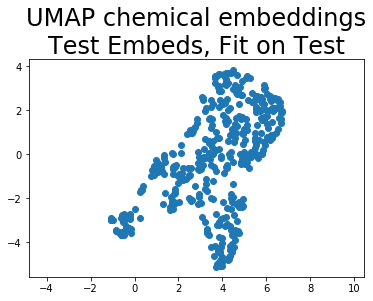

In [81]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(umap_embed_chem_valfit[:, 0], umap_embed_chem_valfit[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP chemical embeddings\nTest Embeds, Fit on Test', fontsize=24);

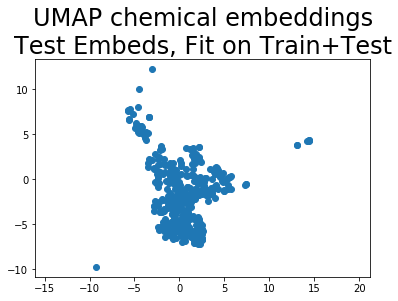

In [82]:
plt.scatter(umap_embed_chem_fitall[:, 0], umap_embed_chem_fitall[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP chemical embeddings\nTest Embeds, Fit on Train+Test', fontsize=24);

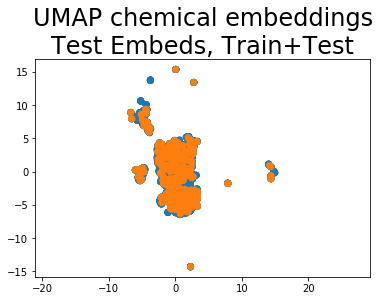

In [83]:
plt.scatter(umap_embed_chem_all[:, 0], umap_embed_chem_all[:, 1],
           c = [sns.color_palette()[x] for x in train_test_stack_labels])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP chemical embeddings\nTest Embeds, Train+Test', fontsize=24);

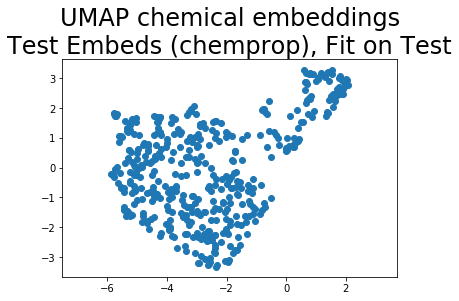

In [84]:
plt.scatter(umap_embed_chemprop_valfit[:, 0], umap_embed_chemprop_valfit[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP chemical embeddings\nTest Embeds (chemprop), Fit on Test', fontsize=24);

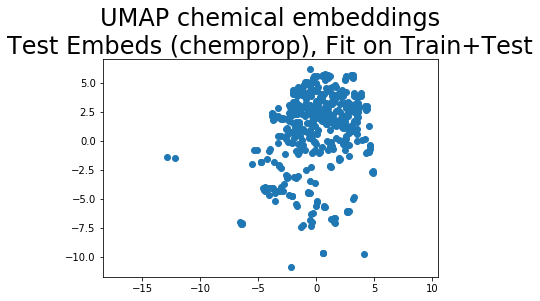

In [85]:
plt.scatter(umap_embed_chemprop_fitall[:, 0], umap_embed_chemprop_fitall[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP chemical embeddings\nTest Embeds (chemprop), Fit on Train+Test', fontsize=24);

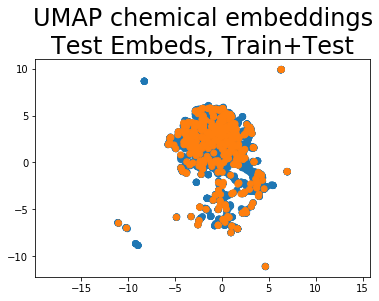

In [86]:
plt.scatter(umap_embed_chemprop_all[:, 0], umap_embed_chemprop_all[:, 1],
           c = [sns.color_palette()[x] for x in train_test_stack_labels])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP chemical embeddings\nTest Embeds, Train+Test', fontsize=24);

## GE Embeddings Visualization

In [87]:
import umap
reducer = umap.UMAP()
umap_embed_ge_valfit = reducer.fit_transform(gex_embeddings_mean_pd)
umap_embed_ge_train = reducer.fit_transform(ge_embeddings_mean_train_pd)

train_test_stack_labels_ge = [0]*ge_embeddings_mean_train_pd.shape[0] + [1]*gex_embeddings_mean_pd.shape[0]
train_test_stack_ge = np.vstack([ge_embeddings_mean_train_pd, gex_embeddings_mean_pd])
umap_embed_ge_all = reducer.fit_transform(train_test_stack_ge)
umap_embed_ge_fitall = reducer.fit(train_test_stack_ge).transform(gex_embeddings_mean_pd)

In [88]:
umap_raw_ge_valfit = reducer.fit_transform(gex_raw_mean_pd)
umap_raw_ge_train = reducer.fit_transform(gex_raw_mean_train_pd)

train_test_stack_ge_raw = np.vstack([gex_raw_mean_train_pd, gex_raw_mean_pd])
umap_raw_ge_all = reducer.fit_transform(train_test_stack_ge_raw)
umap_raw_ge_fitall = reducer.fit(train_test_stack_ge_raw).transform(gex_raw_mean_pd)

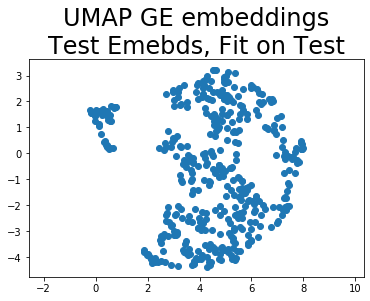

In [89]:
plt.scatter(umap_embed_ge_valfit[:, 0], umap_embed_ge_valfit[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP GE embeddings\nTest Emebds, Fit on Test', fontsize=24);

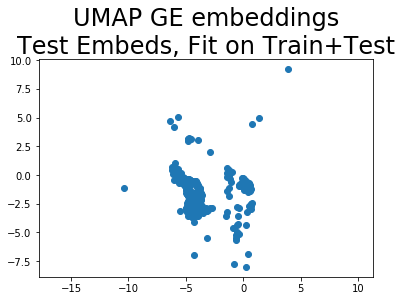

In [90]:
plt.scatter(umap_embed_ge_fitall[:, 0], umap_embed_ge_fitall[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP GE embeddings\nTest Embeds, Fit on Train+Test', fontsize=24);

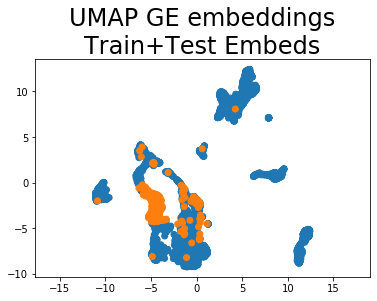

In [91]:
plt.scatter(umap_embed_ge_all[:, 0], umap_embed_ge_all[:, 1],
            c = [sns.color_palette()[x] for x in train_test_stack_labels_ge] )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP GE embeddings\nTrain+Test Embeds', fontsize=24);

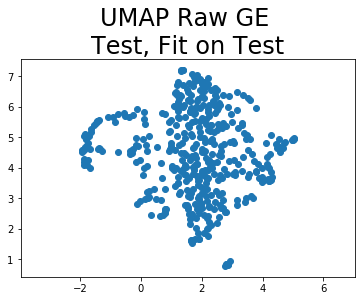

In [92]:
plt.scatter(umap_raw_ge_valfit[:, 0], umap_raw_ge_valfit[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Raw GE \nTest, Fit on Test', fontsize=24);

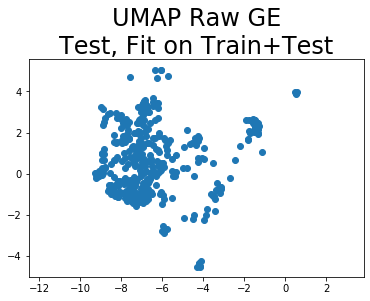

In [93]:
plt.scatter(umap_raw_ge_fitall[:, 0], umap_raw_ge_fitall[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Raw GE\nTest, Fit on Train+Test', fontsize=24);

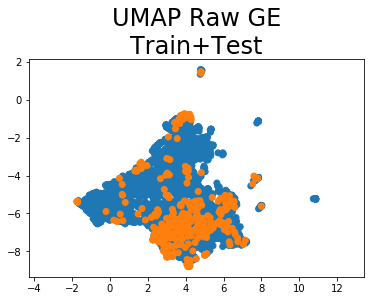

In [94]:
plt.scatter(umap_raw_ge_all[:, 0], umap_raw_ge_all[:, 1],
            c = [sns.color_palette()[x] for x in train_test_stack_labels_ge] )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Raw GE\nTrain+Test', fontsize=24);

## Moleculenet Info

In [95]:
moa = pd.read_hdf("/home/sgf2/DBMI_server/drug_repo/data/moleculenetTasks/MOA.hdf")

all_smiles = np.append(val_dataset.l1000_perts.index.get_level_values("canonical_smiles").values,
                                     train_dataset.l1000_perts.index.get_level_values("canonical_smiles").values)
all_pertids = np.append(val_dataset.l1000_perts.index.get_level_values("pert_id").values,
                                     train_dataset.l1000_perts.index.get_level_values("pert_id").values)

smiles_to_perts = dict(zip(all_smiles, all_pertids))

In [179]:
pertids_chem_labels = [smiles_to_perts[smile] for smile in smiles_chem_labels]
moa_val = moa.loc[pertids_chem_labels].set_index(smiles_chem_labels)
moa_val.sum(axis = 0).sort_values(ascending = False).head(16)

Serotonin receptor antagonist        9.0
Glutamate receptor antagonist        7.0
Cyclooxygenase inhibitor             6.0
Dopamine receptor agonist            6.0
EGFR inhibitor                       5.0
Acetylcholine receptor antagonist    5.0
Phosphodiesterase inhibitor          5.0
Serotonin receptor agonist           5.0
Adrenergic receptor agonist          5.0
Dopamine receptor antagonist         4.0
Adrenergic receptor antagonist       4.0
Retinoid receptor agonist            3.0
Tubulin inhibitor                    3.0
p38 MAPK inhibitor                   3.0
NFkB pathway inhibitor               3.0
PI3K inhibitor                       3.0
dtype: float64

In [97]:
pertids_chem_labels_train = [smiles_to_perts[smile] for smile in smiles_chem_labels_train]
moa_train = moa.loc[pertids_chem_labels_train].set_index(smiles_chem_labels_train)
moa_train.sum(axis = 0).sort_values(ascending = False).head()

Serotonin receptor antagonist      54.0
Dopamine receptor antagonist       52.0
Adrenergic receptor antagonist     48.0
Glucocorticoid receptor agonist    40.0
Cyclooxygenase inhibitor           40.0
dtype: float64

In [98]:
smiles_chem_labels_train_all = np.array(list(smiles_chem_labels_train) + list(smiles_chem_labels))
pertids_chem_labels_all = [smiles_to_perts[smile] for smile in smiles_chem_labels_train_all]
moa_all = moa.loc[pertids_chem_labels_all].set_index(smiles_chem_labels_train_all)

# TODO: color multiple MOAs at the smae time in one plot

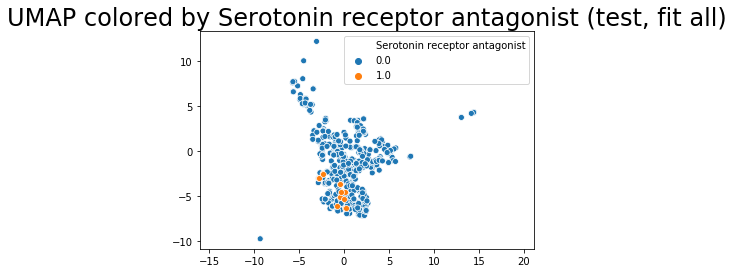

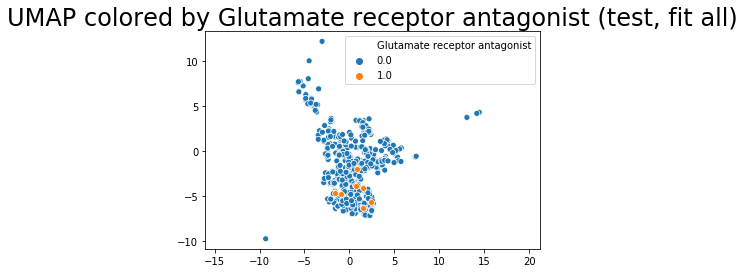

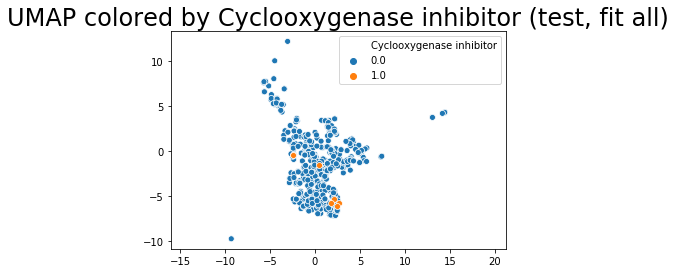

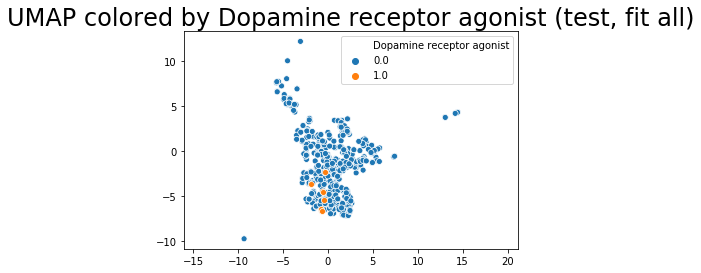

In [99]:
def plot_moa(moa_str='Serotonin receptor antagonist',
             umap_embed_chem = umap_embed_chem_fitall,
             moa = moa_val,
             title_label = 'test, fit all'):
    xlim1 = [-15, 15]
    ylim1 = [-13, 6]

    sns.scatterplot(x=umap_embed_chem[:, 0], y=umap_embed_chem[:, 1],
                hue = moa[moa_str].squeeze())
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP colored by ' + moa_str + ' (' + title_label + ')', fontsize=24);

    inds_moa = moa[moa_str].values.nonzero()[0]
    sns.scatterplot(x=umap_embed_chem[inds_moa, 0], y=umap_embed_chem[inds_moa, 1])
    plt.show()

plot_moa()
plot_moa("Glutamate receptor antagonist")
plot_moa("Cyclooxygenase inhibitor")
plot_moa("Dopamine receptor agonist")

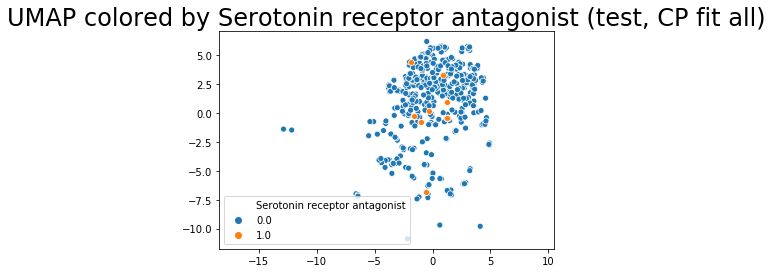

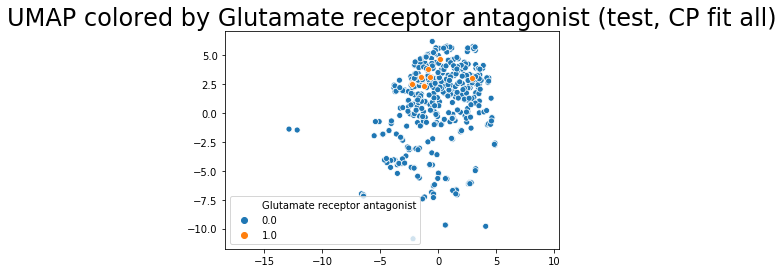

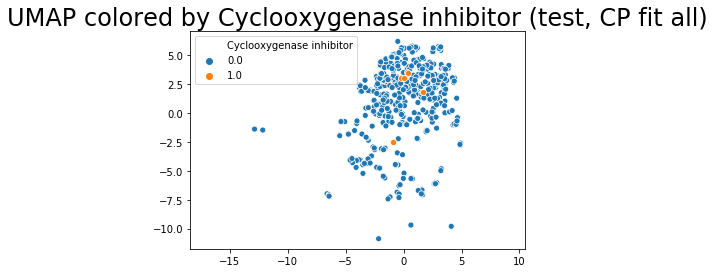

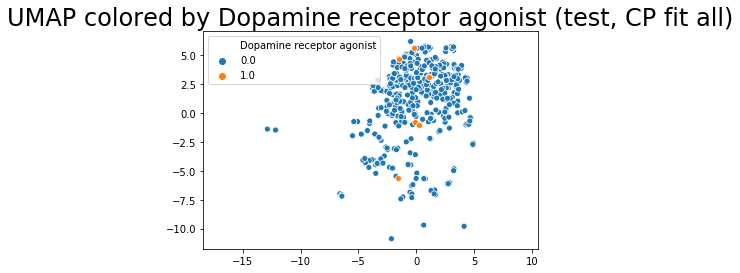

In [112]:
plot_moa(umap_embed_chem = umap_embed_chemprop_fitall,  title_label = 'test, CP fit all')
plot_moa("Glutamate receptor antagonist", umap_embed_chem = umap_embed_chemprop_fitall,  title_label = 'test, CP fit all')
plot_moa("Cyclooxygenase inhibitor", umap_embed_chem = umap_embed_chemprop_fitall,  title_label = 'test, CP fit all')
plot_moa("Dopamine receptor agonist", umap_embed_chem = umap_embed_chemprop_fitall,  title_label = 'test, CP fit all')


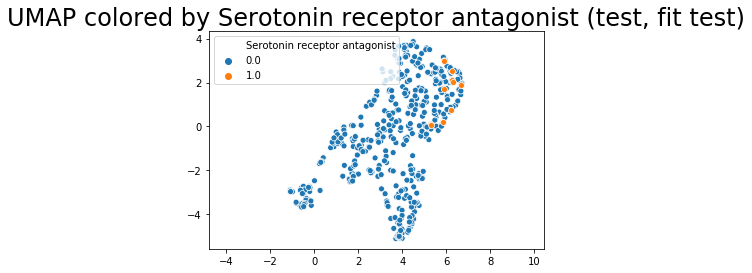

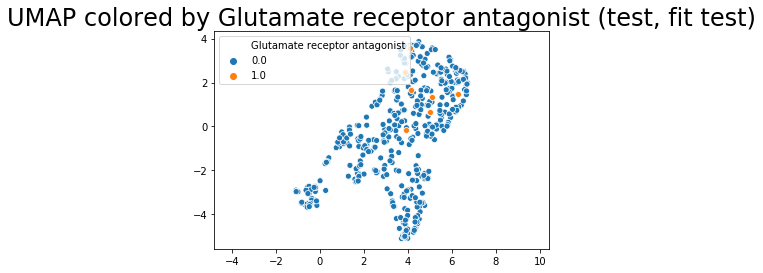

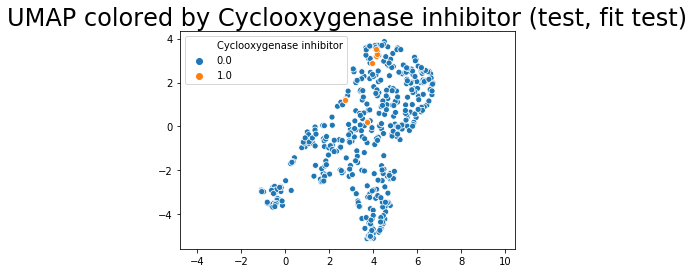

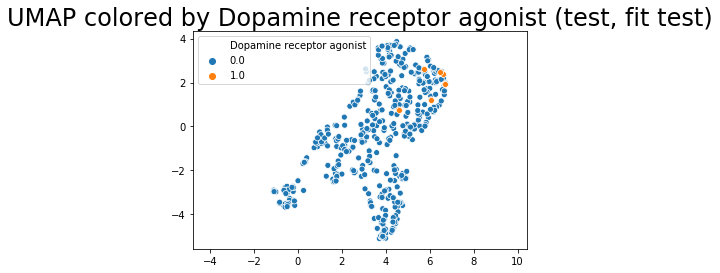

In [117]:
plot_moa(umap_embed_chem = umap_embed_chem_valfit, title_label = 'test, fit test')
plot_moa("Glutamate receptor antagonist", umap_embed_chem = umap_embed_chem_valfit, title_label = 'test, fit test')
plot_moa("Cyclooxygenase inhibitor", umap_embed_chem = umap_embed_chem_valfit, title_label = 'test, fit test')
plot_moa("Dopamine receptor agonist", umap_embed_chem = umap_embed_chem_valfit, title_label = 'test, fit test')

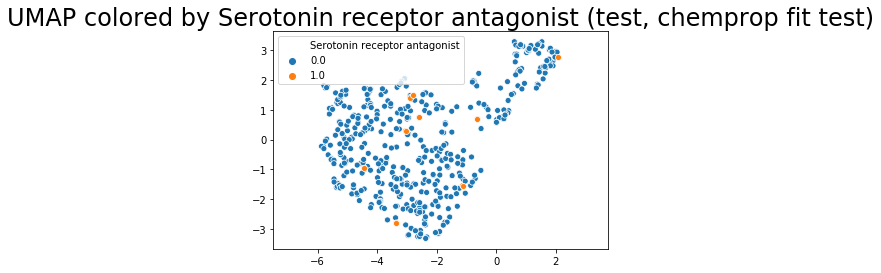

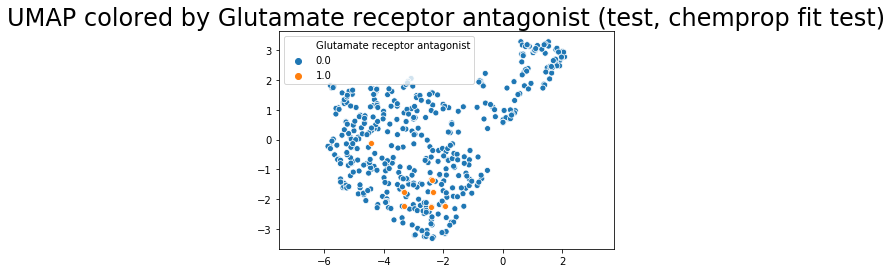

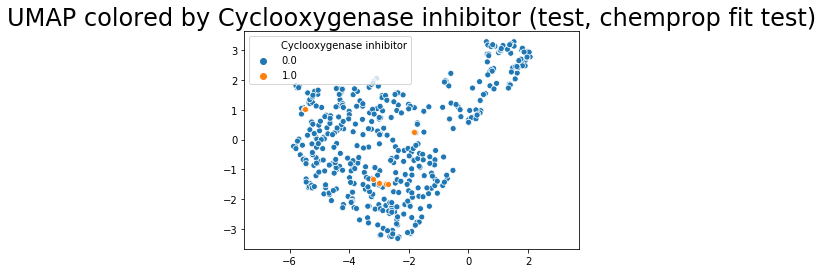

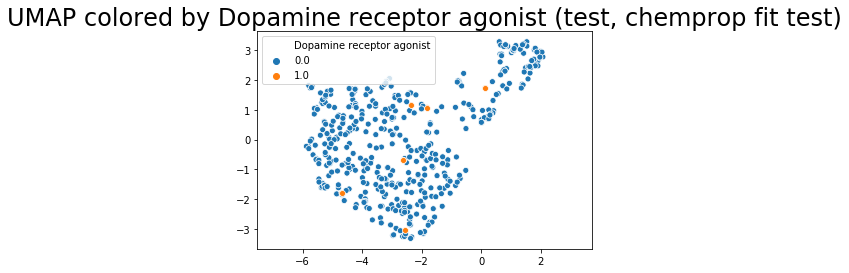

In [116]:
plot_moa(umap_embed_chem = umap_embed_chemprop_valfit, title_label = 'test, chemprop fit test')
plot_moa("Glutamate receptor antagonist", umap_embed_chem = umap_embed_chemprop_valfit, title_label = 'test, chemprop fit test')
plot_moa("Cyclooxygenase inhibitor", umap_embed_chem = umap_embed_chemprop_valfit, title_label='test, chemprop fit test')
plot_moa("Dopamine receptor agonist", umap_embed_chem = umap_embed_chemprop_valfit, title_label='test, chemprop fit test')

# Distance Computations

## Model space

In [118]:
from scipy.spatial.distance import cdist

## Tanimoto similarity

In [119]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import MolFromSmiles,AllChem


In [120]:
ms = [MolFromSmiles(x) for x in smiles_gex_labels]
fps = [FingerprintMols.FingerprintMol(x) for x in ms]

inds = np.triu_indices(2248, k=1)
tanimoto_dists = [1 - DataStructs.FingerprintSimilarity(fps[inds[0][i]],
                                   fps[inds[1][i]])
                  for i in range( len(inds[0]) )
                 ]

In [121]:
ms = [MolFromSmiles(x) for x in smiles_gex_labels]
fingerprints = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms])

ms = [MolFromSmiles(x) for x in smiles_chem_labels]
fingerprints_unique = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms])

ms_train = [MolFromSmiles(x) for x in smiles_gex_labels_train]
fingerprints_train = np.stack([AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=128) for x in ms_train])

fingerprints.shape, fingerprints_unique.shape, fingerprints_train.shape

((2317, 128), (437, 128), (97210, 128))

## Ranking results

In [ ]:
from scipy.stats.mstats import rankdata
import seaborn as sns

def get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels):
    rank_first_match = []
    for i, sml in enumerate(smiles_gex_labels):
        matches = np.where(smiles_chem_labels == sml)[0]
        ranks_matches = gex_chem_ranks[i, matches]
        rank_first_match.append(np.min(ranks_matches))
    rank_first_match = np.array(rank_first_match).squeeze()
    return rank_first_match

def prepare_metrics(rank_first_match, indices):
    median_rank = np.median(rank_first_match[indices])
    mrr = np.mean(1 / rank_first_match[indices])
    hits_at_10 = np.mean(
        [np.sum(results <= 10) for results in rank_first_match[indices]])  # can change to rank_all_matches
    hits_at_100 = np.mean([np.sum(results <= 100) for results in rank_first_match[indices]])
    hits_at_500 = np.mean([np.sum(results <= 500) for results in rank_first_match[indices]])
    return {#"total_drugs": len(set(np.array(smiles_gex_labels)[inds])),
            "median_rank": median_rank,
            "MRR": mrr,
            "H@10": hits_at_10,
            "H@100": hits_at_100,
            "H@500": hits_at_500
        }

def compute_grouped_embeddings(embeddings, labels):
    embeds_to_avg = pd.DataFrame(embeddings, index = labels)
    embeds_to_avg.index.name = "canonical_smiles"
    embeds_to_avg = embeds_to_avg.groupby('canonical_smiles').mean()
    embeddings_avg = embeds_to_avg.values
    smiles_labels_avg = embeds_to_avg.index.values
    return embeddings_avg, smiles_labels_avg

def get_val_scores(distmat,
                   smiles_gex_labels=smiles_gex_labels,
                   smiles_chem_labels=smiles_chem_labels,
                   train_smiles = list(set(smiles_chem_labels_train))):

    gex_chem_ranks = rankdata(distmat, axis=1)

    rank_first_match = get_ranks_first_match(gex_chem_ranks, smiles_gex_labels, smiles_chem_labels)

    list_of_inds = [[i for i,j in enumerate(smiles_gex_labels)]]
    
    ir_results = []
    for inds in list_of_inds:
        ir_results.append(prepare_metrics(rank_first_match, inds))

    val_print_labels = ["Val (All):              "]
    for i, res_dict in enumerate(ir_results):
        print(val_print_labels[i] + "    ".join(['{}: {:.3f}'.format(k, res_dict[k]) for k in res_dict]))

    match_dists = []
    nonmatch_dists = []
    for i, sml in enumerate(smiles_gex_labels):
        match = np.where(smiles_chem_labels == sml)[0]
        match_dists.append(distmat[i,match[0]])
        nonmatch_dists.extend( list(distmat[i,:match[0]]) + list(distmat[i,match[0]+1:]) )
    match_sims = 1-np.array(match_dists)
    nonmatch_sims = 1-np.array(nonmatch_dists)
    
    print("Average correlation between matched GE and Chem embeds (CCA):   ", np.mean(match_sims))
    print("Average correlation between unmatched GE and Chem embeds (CCA): ", np.mean(nonmatch_sims))
    print("Difference: ", np.mean(match_sims) - np.mean(nonmatch_sims) )
    print("Percentage diff: ", (100 * (np.mean(match_sims) - np.mean(nonmatch_sims)) / np.abs(np.mean(match_sims))) )
    print()
    
    sns.distplot(match_sims)
    sns.distplot(nonmatch_sims)
        
    return rank_first_match, match_sims, nonmatch_sims

from sklearn.cross_decomposition import CCA
import time

def cca_cor(ncomp = 50,
            embeds_ge_train=gex_embeddings_train, embeds_ge_val=gex_embeddings,
            embeds_chem_train=chem_embeddings_train, embeds_chem_val=chem_embeddings,
            embeds_chem_uniq_val=chem_embeddings_unique
           ):


    start = time.time()

    print("CCA w/", ncomp, "components")
    cca = CCA(n_components=ncomp, max_iter = 1000)
    cca.fit(embeds_ge_train, embeds_chem_train)
    cca_gex_val, cca_chem_val = cca.transform(embeds_ge_val, embeds_chem_uniq_val)
    
    end = time.time()

    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    print("Computing Distances")
    gex_chem_embed_dist_cca = cdist(cca_gex_val, cca_chem_val,  metric='correlation')
    gex_chem_embed_dist_cca[np.isnan(gex_chem_embed_dist_cca)] = 1
    ranks_val, match_sims, nonmatch_sims = get_val_scores(gex_chem_embed_dist_cca)
    return ranks_val, match_sims, nonmatch_sims

In [201]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler_ge = StandardScaler().fit(gex_raw_train)
ge_transform = scaler_ge.transform(gex_raw)
ge_transform_train = scaler_ge.transform(gex_raw_train)

pca_ge = PCA(n_components=512)
pcs_ge = pca_ge.fit(ge_transform_train)

ge_raw_pca = pcs_ge.transform(ge_transform)
ge_raw_pca_train = pcs_ge.transform(ge_transform_train)

In [204]:
scaler_chem = StandardScaler().fit(chem_embeddings_chemprop_train)
chemprop_transform = scaler_chem.transform(chem_embeddings_chemprop)
chemprop_transform_train = scaler_chem.transform(chem_embeddings_chemprop_train)
chemprop_transform_unique = scaler_chem.transform(chem_embeddings_unique_chemprop)

pca_chem = PCA(n_components=512)
pcs_chem = pca_chem.fit(chemprop_transform_train)

chemprop_embed_pca = pcs_chem.transform(chemprop_transform)
chemprop_embed_train_pca = pcs_chem.transform(chemprop_transform_train)
chem_embed_unique_chempropPCA = pcs_chem.transform(chemprop_transform_unique)

## Compute Results

In [123]:
gex_raw.shape, gex_embeddings.shape, chem_embeddings.shape, chem_embeddings_unique.shape, len(smiles_gex_labels), len(smiles_chem_labels)

((2317, 2934), (2317, 51), (2317, 51), (437, 51), 2317, 437)

Original
Val (All):              median_rank: 126.000    MRR: 0.042    H@10: 0.085    H@100: 0.432    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.24325276913210686
Average correlation between unmatched GE and Chem embeds (CCA):  0.036590154734056704
Difference:  0.20666261439805017
Percentage diff:  84.95796990734969



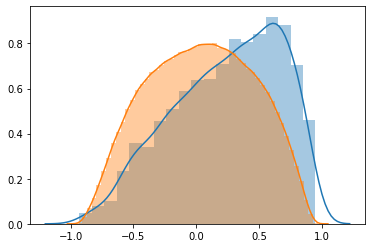

In [124]:
print("Original")
gex_chem_baseline_dist = cdist(gex_embeddings, chem_embeddings_unique,  metric='correlation')
ranks_val_orig, simsM_orig_all, simsNM_orig_all = get_val_scores(gex_chem_baseline_dist)

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 130.000    MRR: 0.048    H@10: 0.093    H@100: 0.425    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.17334946936044618
Average correlation between unmatched GE and Chem embeds (CCA):  0.016052408073727792
Difference:  0.1572970612867184
Percentage diff:  90.73985739157358



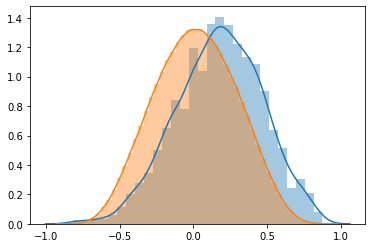

In [125]:
ranks_val_cca, simsM_cca_all, simsNM_cca_all = cca_cor()

CCA w/ 50 components
Computing Distances
Val (All):              median_rank: 177.000    MRR: 0.027    H@10: 0.050    H@100: 0.319    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.04355221524825655
Average correlation between unmatched GE and Chem embeds (CCA):  -0.001280967518155143
Difference:  0.0448331827664117
Percentage diff:  102.941222417398



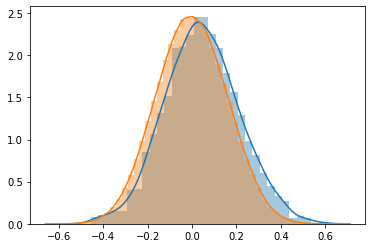

In [126]:
ranks_val_geEmbed_fps_all, simsM_geEmbed_fps_all, simsNM_geEmbed_fps_all = cca_cor(ncomp = 50,
                                                                               embeds_chem_train=fingerprints_train,
                                                                               embeds_chem_val=fingerprints,
                                                                               embeds_chem_uniq_val=fingerprints_unique)

CCA w/ 50 components
00:15:51.62
Computing Distances
Val (All):              median_rank: 180.000    MRR: 0.027    H@10: 0.045    H@100: 0.303    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.031826300042995845
Average correlation between unmatched GE and Chem embeds (CCA):  0.0021522685699778402
Difference:  0.029674031473018003
Percentage diff:  93.23745277625665



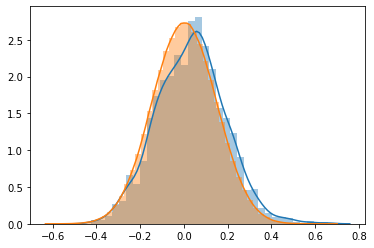

In [202]:
ranks_val_rawGE_fps_all, simsM_rawGE_fps_all, simsNM_rawGE_fps_all = cca_cor(ncomp = 50,
                                                           embeds_ge_train=ge_raw_pca_train,
                                                           embeds_chem_train=fingerprints_train,
                                                           embeds_ge_val=ge_raw_pca,
                                                           embeds_chem_val=fingerprints,
                                                           embeds_chem_uniq_val=fingerprints_unique)

CCA w/ 50 components
00:13:02.90
Computing Distances
Val (All):              median_rank: 134.000    MRR: 0.039    H@10: 0.076    H@100: 0.412    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.07684133658745733
Average correlation between unmatched GE and Chem embeds (CCA):  0.006898899639094442
Difference:  0.06994243694836288
Percentage diff:  91.02189011087486



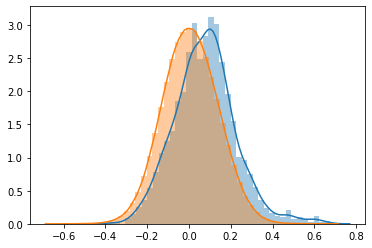

In [203]:
ranks_val_rawGE_chemEmbed_all, simsM_rawGE_chemEmbed_all, simsNM_rawGE_chemEmbed_all = cca_cor(ncomp = 50,
                                                                       embeds_ge_train=ge_raw_pca_train,
                                                                       embeds_ge_val=ge_raw_pca)

CCA w/ 50 components
00:31:25.07
Computing Distances
Val (All):              median_rank: 184.000    MRR: 0.024    H@10: 0.040    H@100: 0.294    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.022725119845623358
Average correlation between unmatched GE and Chem embeds (CCA):  -0.004277491503110461
Difference:  0.02700261134873382
Percentage diff:  118.82274563200716



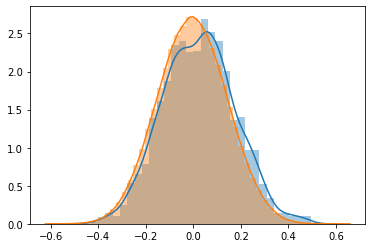

In [205]:
ranks_val_rawGE_chemprop_all, simsM_rawGE_chemprop_all, simsNM_rawGE_chemprop_all = cca_cor(ncomp = 50,
                                                                                            embeds_ge_train=ge_raw_pca_train,
                                                                                            embeds_ge_val=ge_raw_pca,
                                                                                            embeds_chem_train=chemprop_embed_train_pca,
                                                                                            embeds_chem_val=chemprop_embed_pca,
                                                                                            embeds_chem_uniq_val=chem_embed_unique_chempropPCA
                                                                                                                         )

CCA w/ 50 components
00:14:21.54
Computing Distances
Val (All):              median_rank: 163.000    MRR: 0.028    H@10: 0.051    H@100: 0.334    H@500: 1.000
Average correlation between matched GE and Chem embeds (CCA):    0.05139632069001077
Average correlation between unmatched GE and Chem embeds (CCA):  -0.002443707399365954
Difference:  0.053840028089376726
Percentage diff:  104.75463489712584



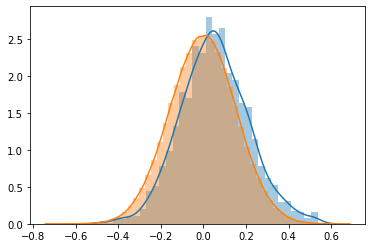

In [206]:
ranks_val_geEmbed_chemprop_all, simsM_geEmbed_chemprop_all, simsNM_geEmbed_chemprop_all = cca_cor(ncomp = 50,
                                                                                                  embeds_chem_train=chemprop_embed_train_pca,
                                                                                                  embeds_chem_val=chemprop_embed_pca,
                                                                                                  embeds_chem_uniq_val=chem_embed_unique_chempropPCA
                                                                                                                         )

## Plots

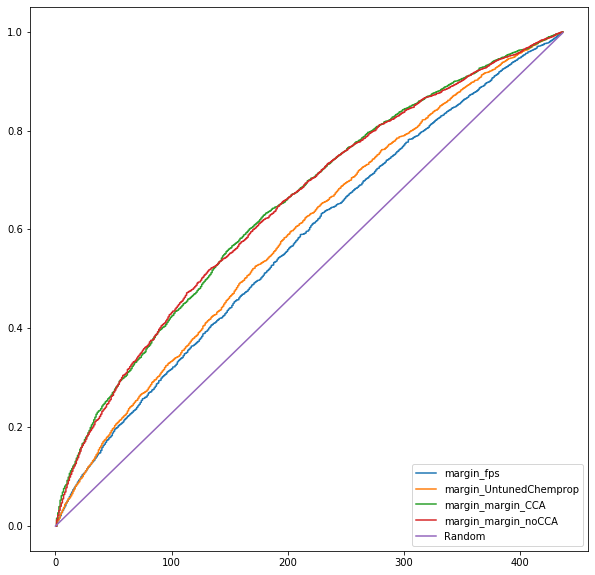

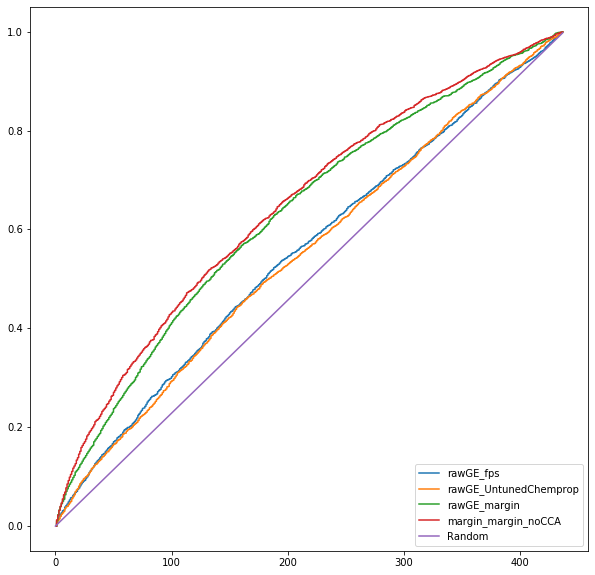

In [208]:
def cdf_plot(data, label):
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), label = label)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
#cdf_plot(ranks_val_rawGE_fps_all, label = 'rawGE_fps')
#cdf_plot(ranks_val_rawGE_chemprop_all, label = 'rawGE_PT')
#cdf_plot(ranks_val_rawGE_chemEmbed_all, label = 'rawGE_margin')
cdf_plot(ranks_val_geEmbed_fps_all, label = "margin_fps")
cdf_plot(ranks_val_geEmbed_chemprop_all, label = "margin_UntunedChemprop")
cdf_plot(ranks_val_cca,  label = "margin_margin_CCA")
cdf_plot(ranks_val_orig, label = "margin_margin_noCCA")
cdf_plot(np.linspace(0, 437, 437), "Random")
plt.legend(loc="lower right")
plt.show()

fig = plt.figure(figsize=(10,10))
cdf_plot(ranks_val_rawGE_fps_all, label = 'rawGE_fps')
cdf_plot(ranks_val_rawGE_chemprop_all, label = 'rawGE_UntunedChemprop')
cdf_plot(ranks_val_rawGE_chemEmbed_all, label = 'rawGE_margin')
#cdf_plot(ranks_val_geEmbed_fps, label = "margin_fps")
#cdf_plot(ranks_val_geEmbed_chemprop_all, label = "margin_PT")
#cdf_plot(ranks_val_cca,  label = "margin_margin_CCA")
cdf_plot(ranks_val_orig, label = "margin_margin_noCCA")
cdf_plot(np.linspace(0, 437, 437), "Random")
plt.legend(loc="lower right")
plt.show()

## Save results


In [142]:
results = (
    (ranks_val_orig, ranks_val_cca,ranks_val_geEmbed_fps_all,ranks_val_rawGE_fps_all,
    ranks_val_rawGE_chemEmbed_all)
    )
with open('../numpy/drug_cell_split.pkl', 'wb') as outfile:
    pickle.dump(results, outfile, pickle.HIGHEST_PROTOCOL)

5

## Analyze Results

## Training Set Similarity

In [133]:
from scipy.spatial.distance import cdist

In [134]:
gex_embeddings.shape, gex_embeddings_train.shape

((2317, 51), (97210, 51))

In [157]:
### Distance in chem space to nearest neighbor in train (per model) -- most relevant to drug split
dists_to_train_chem_embed = cdist(chem_embeddings_unique, chem_embeddings_unique_train,  metric='correlation')

dists_to_train_chem_embed[np.isnan(dists_to_train_chem_embed)] = 1
min_dists_to_train_chem_embed = dists_to_train_chem_embed.min(axis=1)
min_dists_to_train_chem_embed.shape

(437,)

In [136]:
### Distance in chem space to nearest neighbor in train (per model) -- most relevant to drug split
dists_to_train_chemprop = cdist(chem_embeddings_unique_chemprop, chem_embeddings_unique_chemprop_train,  metric='correlation')
min_dists_to_train_chemprop = dists_to_train_chemprop.min(axis=1)
min_dists_to_train_chemprop.shape

(437,)

In [137]:
### Distance in chem space to nearest neighbor in train (per fps) -- most relevant to drug split
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import MolFromSmiles,AllChem

ms = [MolFromSmiles(x) for x in smiles_chem_labels]
fps = [FingerprintMols.FingerprintMol(x) for x in ms]

ms_train = [MolFromSmiles(x) for x in smiles_chem_labels_train]
fps_train = [FingerprintMols.FingerprintMol(x) for x in ms_train]

In [138]:
min_dists_to_train_chem_fps = [np.min([(1 - DataStructs.FingerprintSimilarity(fptrain, fpval)) for fptrain in fps_train]) for fpval in fps]

In [139]:
### Distance in ge space to nearest neighbor in train (per model) -- most relevant to CL split
### Distance in chem space to nearest neighbor in train (per model) -- most relevant to drug split
dists_to_train_ge_embed = cdist(gex_embeddings, gex_embeddings_train,  metric='correlation')
min_dists_to_train_ge_embed = dists_to_train_ge_embed.min(axis=1)
min_dists_to_train_ge_embed.shape

(2317,)

In [143]:
### Distance in ge space to nearest neighbor in train (per raw GE) -- most relevant to CL split
dists_to_train_ge_raw = cdist(gex_raw[:,-978:], gex_raw_train[:,-978:],  metric='correlation')
min_dists_to_train_ge_raw = dists_to_train_ge_raw.min(axis=1)
min_dists_to_train_ge_raw.shape

(2317,)

In [ ]:
### Number of significant genes -- relevant to both

In [144]:
from collections import Counter
counts_gex_smiles = Counter(smiles_gex_labels)

In [145]:
import pandas as pd
ranks_pd = pd.DataFrame(ranks_val_orig, index = smiles_gex_labels)

recip_ranks_pd = 1 / ranks_pd
MRR_by_smiles_pd = recip_ranks_pd.groupby(recip_ranks_pd.index).mean()
MRR_by_smiles_pd = MRR_by_smiles_pd.loc[smiles_chem_labels]

MR_by_smiles_pd = ranks_pd.groupby(ranks_pd.index).median()
MR_by_smiles_pd = MR_by_smiles_pd.loc[smiles_chem_labels]

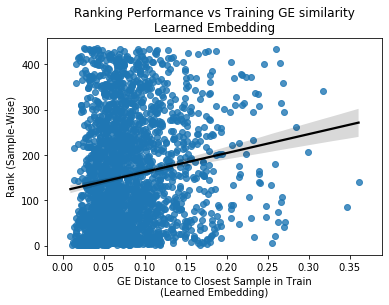

In [146]:
import seaborn as sns
ax = sns.regplot(x = min_dists_to_train_ge_embed, y=ranks_pd.values,
                line_kws={'color':'black'})
ax.set(ylabel='Rank (Sample-Wise)', xlabel='GE Distance to Closest Sample in Train\n(Learned Embedding)',
      title="Ranking Performance vs Training GE similarity\nLearned Embedding")
plt.show()

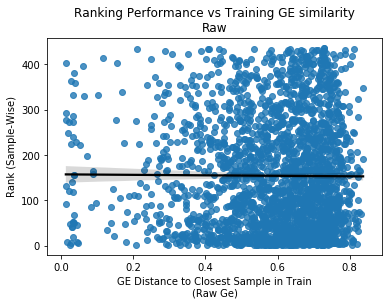

In [147]:
import seaborn as sns
ax = sns.regplot(y = ranks_pd.values, x=min_dists_to_train_ge_raw,
                line_kws={'color':'black'})
ax.set(ylabel='Rank (Sample-Wise)', xlabel='GE Distance to Closest Sample in Train\n(Raw Ge)',
      title="Ranking Performance vs Training GE similarity\nRaw")
plt.show()

In [148]:
### For Cell line only split, the following should be against the number of times the drug appears in the train set

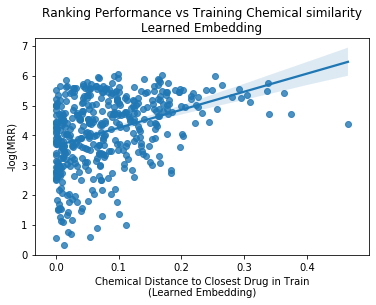

In [160]:
import seaborn as sns
ax = sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=min_dists_to_train_chem_embed)
ax.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Learned Embedding)',
      title="Ranking Performance vs Training Chemical similarity\nLearned Embedding")
plt.show()

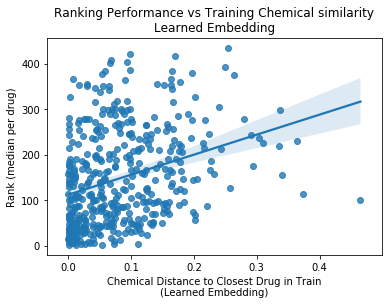

In [159]:
ax = sns.regplot(y = MR_by_smiles_pd.values, x=min_dists_to_train_chem_embed)
ax.set(ylabel='Rank (median per drug)', xlabel='Chemical Distance to Closest Drug in Train\n(Learned Embedding)',
             title="Ranking Performance vs Training Chemical similarity\nLearned Embedding")
plt.show()

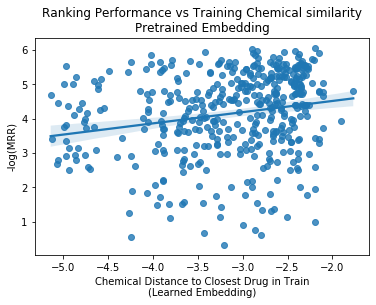

In [162]:
ax = sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=np.log(min_dists_to_train_chemprop))
ax.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Learned Embedding)',
             title="Ranking Performance vs Training Chemical similarity\nPretrained Embedding")
plt.show()

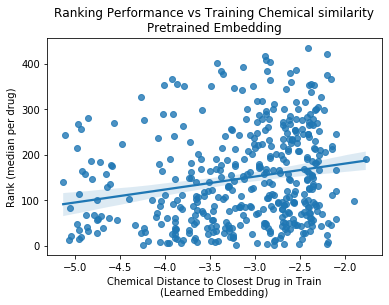

In [181]:
ax = sns.regplot(y = MR_by_smiles_pd.values, x=np.log(min_dists_to_train_chemprop))
ax.set(ylabel='Rank (median per drug)', xlabel='Chemical Distance to Closest Drug in Train\n(Learned Embedding)',
             title="Ranking Performance vs Training Chemical similarity\nPretrained Embedding")
plt.show()

In [163]:
np.corrcoef(min_dists_to_train_chemprop, min_dists_to_train_chem_embed)

array([[1.       , 0.6110365],
       [0.6110365, 1.       ]])

In [164]:
len(min_dists_to_train_chem_fps)

437

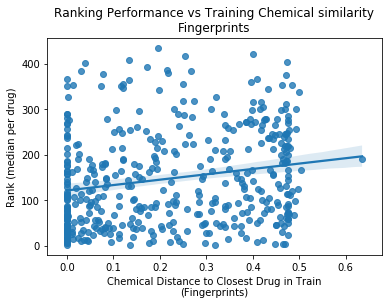

In [165]:
ax = sns.regplot(y = MR_by_smiles_pd.values, x=min_dists_to_train_chem_fps)
ax.set(ylabel='Rank (median per drug)', xlabel='Chemical Distance to Closest Drug in Train\n(Fingerprints)',
             title="Ranking Performance vs Training Chemical similarity\nFingerprints")
plt.show()

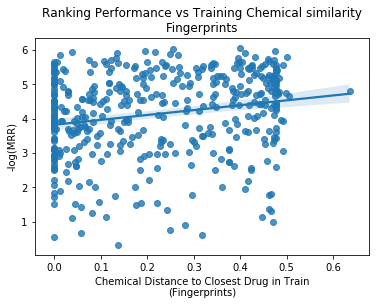

In [166]:
ax = sns.regplot(y = -np.log(MRR_by_smiles_pd.values), x=min_dists_to_train_chem_fps)
ax.set(ylabel='-log(MRR)', xlabel='Chemical Distance to Closest Drug in Train\n(Fingerprints)',
             title="Ranking Performance vs Training Chemical similarity\nFingerprints")
plt.show()

## Gene Counts

In [167]:
pertid_gene_counts = pd.read_csv("/home/sgf2/DBMI_server/drug_repo/data/pert_id_gene_counts.tsv", sep = "\t")
pertid_to_geneCounts = dict(zip(pertid_gene_counts.pert_id.values, pertid_gene_counts.mean_sig_genes.values))

all_smiles = np.append(val_dataset.l1000_perts.index.get_level_values("canonical_smiles").values,
                                     train_dataset.l1000_perts.index.get_level_values("canonical_smiles").values)
all_pertids = np.append(val_dataset.l1000_perts.index.get_level_values("pert_id").values,
                                     train_dataset.l1000_perts.index.get_level_values("pert_id").values)

smiles_to_perts = dict(zip(all_smiles, all_pertids))

smiles_to_gene_counts = {smile:pertid_to_geneCounts[smiles_to_perts[smile]] for smile in all_smiles if smiles_to_perts[smile] in pertid_to_geneCounts}


chem_inds_w_counts = [ind for ind in range(len(smiles_chem_labels)) if smiles_chem_labels[ind] in smiles_to_gene_counts]
chem_gene_counts = [smiles_to_gene_counts[smiles_chem_labels[ind]] for ind in chem_inds_w_counts]

chem_inds_w_counts_train = [ind for ind in range(len(smiles_chem_labels_train)) if smiles_chem_labels_train[ind] in smiles_to_gene_counts]
chem_gene_counts_train = [smiles_to_gene_counts[smiles_chem_labels_train[ind]] for ind in chem_inds_w_counts_train]

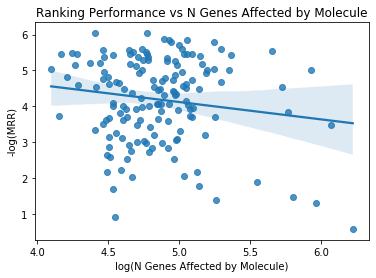

In [168]:
import seaborn as sns
ax = sns.regplot(y = -np.log(MRR_by_smiles_pd.values[chem_inds_w_counts]), x=np.log(chem_gene_counts))
ax.set(ylabel='-log(MRR)', xlabel='log(N Genes Affected by Molecule)',
      title="Ranking Performance vs N Genes Affected by Molecule")
plt.show()

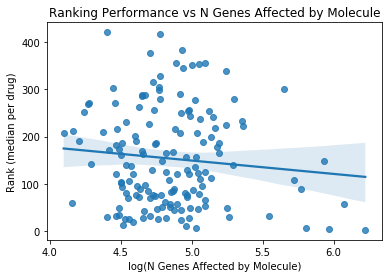

In [169]:
ax = sns.regplot(y = MR_by_smiles_pd.values[chem_inds_w_counts], x=np.log(chem_gene_counts))
ax.set(ylabel='Rank (median per drug)',  xlabel='log(N Genes Affected by Molecule)',
             title="Ranking Performance vs N Genes Affected by Molecule")
plt.show()